#### RNN_Implimentation

#### Step 1: Load and inspect the dataset

In [20]:
import pandas as pd
# Load the dataset
df = pd.read_csv('rnn_sensor_data.csv')
# Show first 5 rows
df.head()

,temperature,vibration,pressure,performance_index
0,0.049671,0.472453,0.034829,-0.165201
1,0.006172,0.497070,0.028832,-0.146194
2,0.104758,0.455081,-0.092652,-0.077254
3,0.212267,0.512944,0.059458,0.016974
4,0.056499,0.608590,-0.147008,-0.056961


In [21]:
# Show basic info and stats
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        10000 non-null  float64
 1   vibration          10000 non-null  float64
 2   pressure           10000 non-null  float64
 3   performance_index  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB
None


In [22]:
print(df.describe())

        temperature     vibration      pressure  performance_index
count  10000.000000  10000.000000  10000.000000       10000.000000
mean       0.002394     -0.002931      2.498504           0.251255
std        0.714484      0.712604      1.446893           0.410038
min       -1.311971     -1.357496     -0.248419          -0.750811
25%       -0.694471     -0.693694      1.239071          -0.076753
50%        0.009477     -0.004069      2.494143           0.251119
75%        0.700943      0.696420      3.747943           0.574135
max        1.368638      1.267052      5.222683           1.282965


#### Step 2: Prepare Data for RNN Scaling and Creating Sequences

In [23]:
import numpy as np                                  # Import NumPy for numerical operations
from sklearn.preprocessing import StandardScaler    # Import StandardScaler for feature scaling

# Extract features (temperature, vibration, pressure) from dataframe and convert to NumPy array
features = df[['temperature', 'vibration', 'pressure']].values

# Extract target variable (performance_index) from dataframe and convert to NumPy array
target = df['performance_index'].values

# Initialize scaler for features to normalize them (zero mean, unit variance)
scaler_x = StandardScaler()

# Initialize scaler for target to normalize it similarly
scaler_y = StandardScaler()

# Fit scaler to features and transform them
features_scaled = scaler_x.fit_transform(features)
# Reshape target to 2D array (required by scaler), then fit and transform
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))
# Define the number of past time steps to include in each input sequence
SEQ_LENGTH = 20

# Function to create sequences of features and corresponding target values for RNN training
def create_sequences(X, y, seq_length=SEQ_LENGTH):
    X_seq = []  # List to store feature sequences
    y_seq = []  # List to store corresponding targets
    for i in range(len(X) - seq_length):             # Loop through data to create sequences
        X_seq.append(X[i:i+seq_length])               # Append a sequence of length seq_length
        y_seq.append(y[i+seq_length])                 # Append the target immediately following the sequence
    return np.array(X_seq), np.array(y_seq)           # Convert lists to NumPy arrays and return
# Create sequences and targets using the scaled features and target
X_seq, y_seq = create_sequences(features_scaled, target_scaled)
# Print the shape of input sequences: (number of samples, sequence length, number of features)
print(f'Shape of input sequences: {X_seq.shape}')  # Expected shape example: (num_samples, 20, 3)
# Print the shape of targets: (number of samples, 1)
print(f'Shape of targets: {y_seq.shape}')          # Expected shape example: (num_samples, 1)


Shape of input sequences: (9980, 20, 3)
Shape of targets: (9980, 1)


#### Step 3: Split data into training and testing sets

In [24]:
from sklearn.model_selection import train_test_split  # Import function to split dataset into train and test sets
# Split the sequences and targets into training and testing sets
# test_size=0.2 means 20% of the data will be used for testing
# random_state=42 ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq,         # Input sequences (features)
    y_seq,         # Corresponding targets
    test_size=0.2, # Proportion of dataset to include in the test split
    random_state=42 # Seed for random number generator to get same split every run
)
# Print the shapes of the training data (features and targets)
print(f'Training data shape: {X_train.shape}, {y_train.shape}')
# Print the shapes of the testing data (features and targets)
print(f'Testing data shape: {X_test.shape}, {y_test.shape}')

Training data shape: (7984, 20, 3), (7984, 1)
Testing data shape: (1996, 20, 3), (1996, 1)


#### Step 4: Build the RNN model

In [26]:
import tensorflow as tf                                 # Import TensorFlow library
from tensorflow.keras.models import Sequential         # Import Sequential model API
from tensorflow.keras.layers import SimpleRNN, Dense   # Import SimpleRNN and Dense layers
# Define a Sequential model by stacking layers
model = Sequential([
    # Add a SimpleRNN layer with 50 units, tanh activation,
    # and input shape corresponding to sequence length and number of features
    SimpleRNN(50, activation='tanh', input_shape=(SEQ_LENGTH, 3)),
    # Add a Dense (fully connected) hidden layer with 20 units and ReLU activation
    Dense(20, activation='relu'),

    # Add a Dense output layer with 1 unit (for regression output)
    Dense(1)
])
# Compile the model specifying optimizer and loss function
# 'adam' optimizer is a popular adaptive gradient optimizer
# 'mse' (mean squared error) is used as the loss function for regression
model.compile(optimizer='adam', loss='mse')

c:\Users\yitayew\Desktop\Projects\RNN\RNN_ENV\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Print the model summary showing layers, output shapes, and number of parameters
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,741 (14.61 KB)

 Trainable params: 3,741 (14.61 KB)

 Non-trainable params: 0 (0.00 B)

#### Step 5: Train the model

In [28]:
history = model.fit(
    X_train,                # Training input sequences (features)
    y_train,                # Training target values
    validation_split=0.1,   # Use 10% of training data as validation set to monitor model performance during training
    epochs=20,              # Number of times to iterate over the entire training dataset
    batch_size=64           # Number of samples processed before the model's weights are updated
)


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1069 - val_loss: 0.0435
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0438 - val_loss: 0.0412
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0418 - val_loss: 0.0419
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0409 - val_loss: 0.0435
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0402 - val_loss: 0.0431
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0398 - val_loss: 0.0389
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0400 - val_loss: 0.0414
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0391 - val_loss: 0.0420
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0389 - val_loss: 0.0404
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0384 - val_loss: 0.0409
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378 - val_loss: 0.0397
Epoch 12/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

#### Step 6: Evaluate the model on test data

In [29]:
# Evaluate the trained model on the test dataset and compute the loss (MSE)
test_loss = model.evaluate(X_test, y_test)

# Print the test loss with 4 decimal places, representing mean squared error on test data
print(f'Test MSE loss: {test_loss:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Test MSE loss: 0.0413


#### Step 7: Make predictions and visualize results

In [30]:
import matplotlib.pyplot as plt               # Import matplotlib for plotting graphs

# Use the trained model to predict target values on the test input sequences (scaled)
y_pred_scaled = model.predict(X_test)

# Convert the scaled predicted values back to the original scale using inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Convert the scaled true target values back to the original scale
y_true = scaler_y.inverse_transform(y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#### Accuracy of the Model

In [33]:
import matplotlib.pyplot as plt               # Import matplotlib for plotting graphs
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
# Use the trained model to predict target values on the test input sequences (scaled)
y_pred_scaled = model.predict(X_test)
# Convert the scaled predicted values back to the original scale using inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
# Convert the scaled true target values back to the original scale
y_true = scaler_y.inverse_transform(y_test)
# Calculate R² score (higher is better, max 1.0)
r2 = r2_score(y_true, y_pred)
# Calculate Mean Absolute Error (MAE) (lower is better)
mae = mean_absolute_error(y_true, y_pred)
print(f'R² Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R² Score: 0.9579
Mean Absolute Error: 0.0657


#### Plot the Values

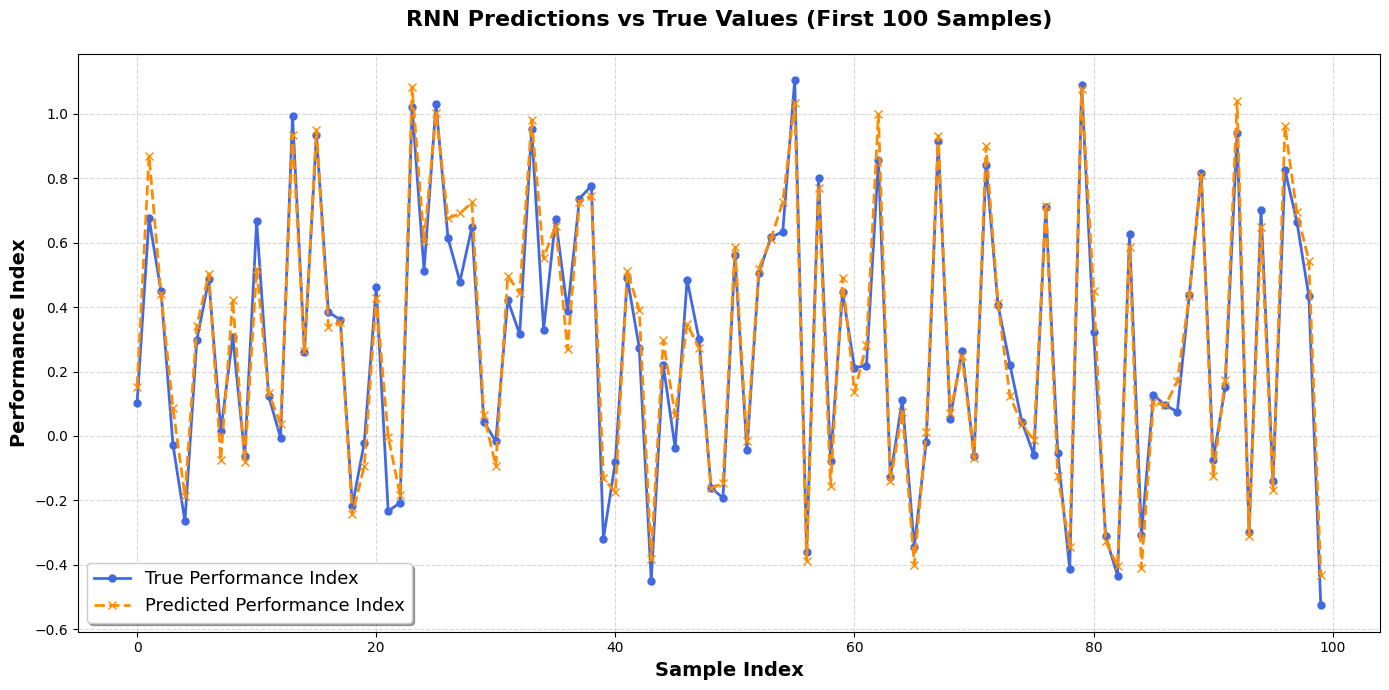

In [34]:
plt.figure(figsize=(14,7))  # Bigger figure for better clarity

# Plot true values with a solid blue line and circle markers
plt.plot(y_true[:100], label='True Performance Index', color='royalblue', linewidth=2, marker='o', markersize=5)

# Plot predicted values with a dashed orange line and x markers
plt.plot(y_pred[:100], label='Predicted Performance Index', color='darkorange', linewidth=2, linestyle='--', marker='x', markersize=6)

# Add grid with light gray lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Axis labels with slightly bigger font and bold style
plt.xlabel('Sample Index', fontsize=14, fontweight='bold')
plt.ylabel('Performance Index', fontsize=14, fontweight='bold')

# Title with increased font size and padding
plt.title('RNN Predictions vs True Values (First 100 Samples)', fontsize=16, fontweight='bold', pad=20)

# Legend with a fancy frame and larger font size
plt.legend(frameon=True, fontsize=13, shadow=True)

# Tight layout for neat spacing
plt.tight_layout()

# Show the plot
plt.show()


#### Model Loss During Training 

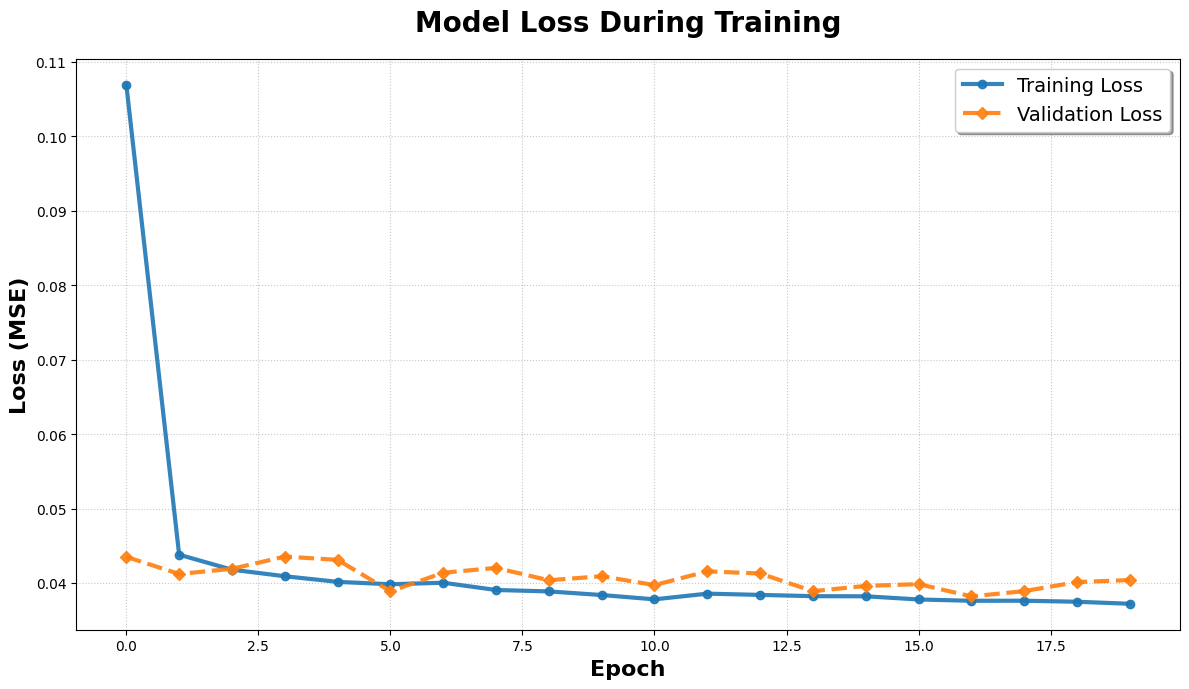

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))

# Plot training loss with solid line, circle markers, and shadow effect
plt.plot(history.history['loss'], label='Training Loss', 
         color='#1f77b4', linewidth=3, marker='o', markersize=6, alpha=0.9)

# Plot validation loss with dashed line, diamond markers, and shadow effect
plt.plot(history.history['val_loss'], label='Validation Loss', 
         color='#ff7f0e', linewidth=3, linestyle='--', marker='D', markersize=6, alpha=0.9)

# Title with padding and bold font
plt.title('Model Loss During Training', fontsize=20, fontweight='bold', pad=20)

# Axis labels with increased font size and bold style
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=16, fontweight='bold')

# Legend with fancy frame, shadow, and larger font size
plt.legend(frameon=True, fontsize=14, shadow=True)

# Grid with more subtle style
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)

# Tight layout for neat spacing
plt.tight_layout()

plt.show()


#### Save the Model

In [36]:
# Save in native Keras format (recommended for TensorFlow >= 2.19)
model.save("saved_rnn_model.keras")